
> + Input: the sequence of S-LAMP images that you obtained. We can show a few sample frames.
> 
> + Output: markers (with different colors or numbers) of all detection initiate points of LAMP reaction overplayed on the last S-LAMP image, and a plot with horizontal axis as time showing the time where each reaction starts (in different plots in the corresponding colors with the spatial markers) and their evolution (e.g. the increasing radius of their expanding wavefront for the vertical axis).
> 

In [61]:
from glob import glob
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib
from skimage.filters import threshold_otsu, median
from skimage.morphology import opening, disk
from skimage import measure
from scipy.ndimage.filters import maximum_filter
%matplotlib inline
matplotlib.rcParams.update({'font.size': 15})
import matplotlib.colors as colors
import matplotlib.patches as patches
from collections import Counter
from matplotlib_scalebar.scalebar import ScaleBar

# matplotlib.rcParams.update({'figure.autolayout': True})
plt.gcf().subplots_adjust(bottom=0.5,  wspace=0.8, top=0.8)
# plt.gcf().subplots_adjust(top=0.88)
# plt.tight_layout()

In [4]:
start_range = [0, 240, 480, 720, 960, 1200]
end_range = [90, 330, 570, 810, 1050, 1280]
max_val = 25000
colors_list = colors.cnames.keys()

### Load the data

In [5]:
CURR_DIR = 'EHV4 LOD 0/'
print(CURR_DIR)

EHV4 LOD 0/


In [6]:
files = glob(CURR_DIR + '*.tif')
num_images = len(files)

index = np.zeros((num_images-1))    
for file in files:
    slide = file.split(' ')[-1].split('.')[0]
    if 'captured' in slide:
        ref_file = file
        files.remove(file)

files.sort(key = lambda x: int(x.split(' ')[-1].split('.')[0]))

In [7]:
images = np.zeros((num_images, 1024, 1280))
i = 0
for file in files:
    image = np.array(np.float32(Image.open(file)))
    images[i, :, :] = image
    i += 1

### Functions for blob identification

In [8]:
# ENSURE NUM_IMAGES less than 10 before running plot_channel
def plot_channel_through_time(images, channel_num, num_images=5, max_val=25000):
    plt.figure(figsize=(18, 10))
    plt.title('Channel through time')
    
    for index in range(num_images):
        image = images[index, :, start_range[channel_num]:end_range[channel_num]]
        plt.subplot(1*100+num_images*10+index+1)
        plt.imshow(image, cmap=plt.cm.gray)
        plt.clim(0, max_val)
        
    plt.show()
    plt.savefig('orig.png')
    return 

In [9]:
def obtain_blobs_td(images_orig, images, channel_num, num_images=20, plot_bool=True):
       
    regions = []
    times = []
    regions_start = []
    intensity = []
    total_intensity = []
    
    for index in range(num_images):
        image = images[index, :, start_range[channel_num]:end_range[channel_num]]
        total_intensity.append(np.mean(images_orig[index, :, start_range[channel_num]:end_range[channel_num]]))
        
        # basic filtering and thresholding
        image = maximum_filter(image, size=10)
        thresh = threshold_otsu(image)
        binary = image > thresh
        
        # morphological operations and labelling
        morphed = opening(binary, disk(6))
        morphed = measure.label(morphed)
        
        new_regions = []
    
        for component in range(1, morphed.max()+1):
            component_size = np.sum(1.*(morphed==component))
            curr_region = 1.*(morphed==component)
            mean_intensity = np.sum(image[morphed==component])*1.0/component_size 
            
            # remove small bright regions (probably noise)
            if (component_size<0.01*np.size(morphed)):
                morphed[morphed==component]=0
            # remove dark regions (probably noise)
            elif (mean_intensity < 0.15*max_val):
                morphed[morphed==component]=0
            else:
                new_regions.append(1.*(morphed==component))
          
        for curr_region in new_regions:
            # check if new region overlaps with existing region. 
            # if so, extend region. else, add new region
            overlap_flag = False
            for region_idx in range(len(regions)):
                region = regions[region_idx]
                overlap = 1.*(curr_region + region == 2)
                if (np.sum(overlap)!= 0):
                    overlap_flag = True
                    regions[region_idx] = 1.*(curr_region + region != 0)
            if overlap_flag == False:
                regions.append(curr_region)
                regions_start.append(curr_region)
                times.append(index)
       
        morphed = measure.label(morphed)    
        
        if(plot_bool):
            plt.figure(figsize=(18,10))

            for region_idx in range(len(regions)):
                region = regions[region_idx]
                plt.subplot(1*100+len(regions)*10+region_idx+1)
                plt.imshow(region, cmap='gray')
                plt.title('Started at '+ str(times[region_idx]))
            plt.savefig('detected.png')
            plt.show()

    intensity = np.zeros((len(regions), num_images))
    for region_idx in range(len(regions)):
        image_set = images_orig[:, :, start_range[channel_num]:end_range[channel_num]]
        valid_region = regions_start[region_idx]!=0
        
        for index in range(0, num_images):  # times[region_idx], num_images):
            image = image_set[index, :, :]
            image_avg_intensity = np.mean(image[valid_region])
            intensity[region_idx, index] = image_avg_intensity
        
    min_intensities = np.reshape(np.min(intensity, axis=1), (len(regions), -1))
    max_intensities = np.reshape(np.max(intensity, axis=1), (len(regions), -1))
    
    print(np.shape(np.reshape(np.min(intensity, axis=1), (len(regions), -1))))
    intensity = (intensity-min_intensities)*1.0/(max_intensities - min_intensities)
    
    min_total = np.min(total_intensity)
    max_total = np.max(total_intensity)
    total_intensity = (total_intensity-min_total)*1.0/(max_total - min_total)
#     total_intensity = 0
    return regions_start, times, intensity, total_intensity

In [10]:
def plot_start_blobs(regions, times, start_time, num_images):

    plt.figure()
    plt.title('Initiation times of bright regions')
    plt.xlabel('Time (in minutes)')
    plt.ylabel('Number of bright regions')
    initiate_times = np.array(times) #  + start_time + 1
    cnt_init_times = Counter(initiate_times)
    
    cnt_times = np.zeros((start_time + num_images+3))
    for idx in range(1, num_images):
        cnt_times[idx + start_time] = cnt_init_times[idx]+cnt_times[idx+start_time-1]
    for idx in range(3):
        cnt_times[num_images+idx+start_time] = len(times)+cnt_init_times[idx+num_images+start_time-1]
        
    plt.step(np.arange(start_time + num_images + 3), cnt_times,  where='post')
#     for idx in range(len(times)):
#         plt.stem([initiate_times[idx]]+0.1*np.random.randn(1), [cum_val[idx]], colors_list[idx], '-', markerfmt='ko')
    plt.xticks(np.arange(0, start_time + num_images + 3, 2.0))
    plt.xlim(start_time-3, num_images+start_time+3)
    plt.ylim(0,len(times)+1)
    plt.savefig('start_points.png')
    plt.show()
    
    return

In [96]:
def plot_blobs_color(images, regions, times, channel_num, start_time, num_images=20):
    
    fig, ax = plt.subplots(1, len(times), figsize=(8, 12))
        
    fig.suptitle('Regions Detected Through Time', fontsize=22, position=(0.5, 0.98))
    image_idx = -1
    
    for index in times:
        image_idx += 1
        image = images[index, :, start_range[channel_num]:end_range[channel_num]]
        
        ax[image_idx].imshow(image, cmap=plt.cm.gray)
        ax[image_idx].set_title(str(index+start_time) + ' min', size='large', position=(0.4, 0.99),
                     horizontalalignment='center', verticalalignment='bottom') 
#         if index == times[0]:
#             scalebar = ScaleBar(1, 'um') 
#             scalebar.box_color = 'k'
#             scalebar.color = 'w'
#             scalebar.location = 'center left'
#             plt.gca().add_artist(scalebar)
        idx = 0
        for region_idx in range(len(times)):
            if (times[region_idx] <= index):
                region = regions[region_idx]
                curr_center = np.mean(np.nonzero(np.array(region)), axis=1)
                rect = patches.Rectangle((curr_center[1]-25, curr_center[0]-25),50,50,linewidth=4,
                                         edgecolor=colors_list[idx], 
                                         facecolor='none')
                ax[image_idx].add_patch(rect)
            idx += 1
    plt.savefig('regions_through_time.png')
    plt.show()

In [12]:
def plot_intensity(intensity, start_time, num_images, total_intensity):
#     intensity = np.shape(intensity)
    plt.figure()
    for idx in range(np.shape(intensity)[0]):
        plt.plot(intensity[idx, :], colors_list[idx], label='Region '+str(idx+1))
    plt.xlim(0, num_images)
#     plt.xlim(start_time, start_time + num_images)
    plt.xlabel('Time (Minutes)')
    plt.ylabel('Scaled Intensity')
    plt.plot(total_intensity, 'k', label='Overall')
    plt.title('Scaled Intensity Variation with Time')
    plt.legend()
    plt.savefig('intensity.png', pad_inches=2)
    plt.show()

In [13]:
channel_num = 2
num_images = 20
start_image = 10
image_subset = images[start_image:start_image+num_images, :, :]
image_diff_subset = images[start_image:start_image+num_images, :, :] - \
                    images[start_image-1:start_image+num_images-1, :, :]

In [16]:
# ENSURE NUM_IMAGES less than 10 before setting plot bool as True
regions, times, intensity, total_intensity = obtain_blobs_td(image_subset, image_diff_subset, 
                                                             channel_num, num_images=num_images,
                                                             plot_bool=False)

(5, 1)


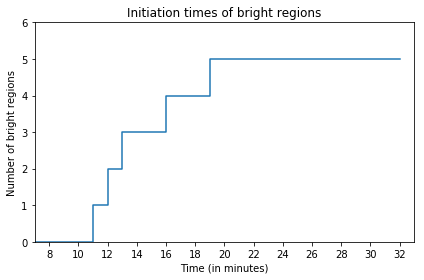

In [20]:
plot_start_blobs(regions, times, start_image, num_images)

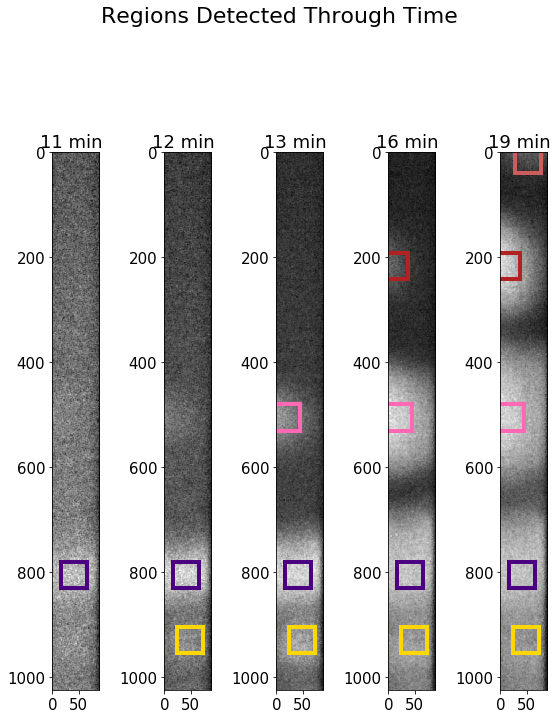

In [97]:
plt.gcf().subplots_adjust(bottom=0.15,  wspace=0.8, top=0.65)
plot_blobs_color(image_subset, regions, times, channel_num, start_image, num_images)

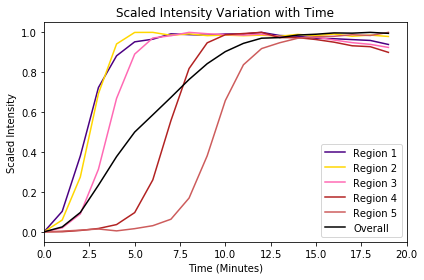

In [19]:
plot_intensity(intensity, start_image, num_images, total_intensity)